In [14]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2

from torchvision import transforms
from skimage import transform

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.options.display.max_rows = 5

In [2]:
dpath = "/Users/sai/Downloads/MURA-v1.1/"

In [3]:
os.listdir(dpath + 'valid')

['XR_HAND',
 'XR_HUMERUS',
 '.DS_Store',
 'XR_FINGER',
 'XR_ELBOW',
 'XR_SHOULDER',
 'XR_WRIST',
 'XR_FOREARM']

In [4]:
 os.listdir(dpath)

['valid',
 '.DS_Store',
 'train_labeled_studies.csv',
 'valid_image_paths.csv',
 'train',
 'valid_labeled_studies.csv',
 'train_image_paths.csv']

In [5]:
train_labels = pd.read_csv(dpath + 'train_labeled_studies.csv', header=None)
train_labels.columns = ['path', 'label']

In [74]:
class pca_tsne_bpart():
    def __init__(self, paths, n_studies=20, resize_res=(100,100), bpart='ELBOW', mode='norm_abnorm'):
        self.paths = paths # paths and label csv file imported as dataframe
        self.n_studies = n_studies # number of studies to consider (each study generally has 3 images)
        self.resize_res = resize_res # resolution of resized image (h*w becomes the dimensions now)
        self.bpart = bpart # body part
        self.prefix = '/Users/sai/Downloads/' # CHANGE THIS ACCORDING TO YOUR DATA PATH!!!
        self.mode = mode
        
        self.df = pd.DataFrame() # original flattened dataframe initiation
    
    
    # Selects image paths randomly (from .csv file randomly for specified body part)
    def select_images_paths(self, label):
        subset = ( self.paths[self.paths.path.str.contains(self.bpart)]
                  .query("label == @label") )
        
        # randomly select 'n_studies' number of paths (each path generally has 3 images)
        rperm = np.random.permutation(subset.shape[0])
        
        subset = subset.iloc[rperm[:self.n_studies], :].reset_index().drop(['index'], axis=1)
        return(subset)
    
    
    def select_images_paths_bpart(self):
        # randomly select 'n_studies' number of paths (each path generally has 3 images)
        rperm = np.random.permutation(self.paths.shape[0])
        subset = self.paths.iloc[rperm[:self.n_studies], :].reset_index().drop(['index'], axis=1)
        return(subset)
    
    
    # Applies transformations (just resize and adaptive thresholding for now)
    def transform_image(self, img_gray):
        
        # Multiplied by 255 because adaptive thresholding requires 8-bit 1-channel data
        img_tr = transform.resize(img_gray, self.resize_res, mode='constant') * 255
        img_tr = img_tr.astype(np.uint8)
        
#         img_tr = cv2.adaptiveThreshold(img_tr, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        return(img_tr)
    
    
    # Takes the transformed image and flattens it (Fortran style) and concats it to a dataframe
    def flatten_image_to_df(self, img, label, path):
        n_cols = img.shape[0] * img.shape[1]
        img_flat = img.reshape((1,n_cols), order='F')
        img_flat_df = pd.DataFrame(img_flat)
        
        if self.mode == 'norm_abnorm':
            img_flat_df['label'] = label
        elif self.mode == 'bpart':
            img_flat_df['label'] = path.split('_')[1].split('/')[0]
        self.df = pd.concat([self.df, img_flat_df], sort=True)
        
    
    # Main data pipe function: selects image paths, transforms and appends to df using helper functions
    def collect_images(self, label=0):
        if self.mode == 'norm_abnorm':
            label_paths = self.select_images_paths(label)
        elif self.mode == 'bpart':
            label_paths = self.select_images_paths_bpart()
        
        for i in range(label_paths.shape[0]):
            path = self.prefix + label_paths.loc[i,'path']
            suffixes = os.listdir(path)
            
            for suffix in suffixes:
                full_path = path + suffix
                img = cv2.imread(full_path)
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_tr = self.transform_image(img_gray)
                
                # Uncomment below to view images (make sure you change n_studies in instantiation to a few
                # to prevent overwhelming the console)
                plt.imshow(img_tr, cmap='gray')
                plt.show()
                
                self.flatten_image_to_df(img_tr, label, path)
                
                    
    # Performs PCA on original flattened image data and creates new dataframe with principal components
    def perform_pca(self, n_comp=2):
        self.collect_images(label=0)
        self.collect_images(label=1)
        
        self.df_cols = [ 'px_'+str(i) for i in range(self.df.shape[1]-1) ]
        self.df.columns = self.df_cols + ['label']
        self.df = self.df.reset_index().drop(['index'], axis=1)

        pca = PCA(n_components=n_comp).fit(self.df.loc[:, self.df_cols].values)
        pca_result = pca.transform(self.df.loc[:, self.df_cols].values)
        
        self.df_pca = pd.DataFrame(pca_result)
        self.df_pca.columns = [ 'pca_'+str(i+1) for i in range(self.df_pca.shape[1]) ]
        self.df_pca['label'] = self.df.label
        
        print(pca.explained_variance_ratio_.sum())
        sns.scatterplot(x='pca_1', y='pca_2', data=self.df_pca, 
                hue='label', alpha=0.9, legend='full', palette=sns.color_palette("bright", 2))
        plt.show()
        
        return(pca, pca_result)
    
    
    # Performs TSNE on original image data or PCA results and creates a new df
    def perform_tsne(self, n_comp=2, perplexity=50, learning_rate=200):
        tsne = TSNE(n_components=n_comp, verbose=0, perplexity=perplexity, n_iter=1000, 
                    learning_rate=learning_rate)
        
        # Uncomment below line to perform tsne on original data
        tsne_result = tsne.fit_transform(self.df.loc[:, self.df_cols].values)

        # Uncomment below line to perform tsne on PCA result data
#         tsne_result = tsne.fit_transform(self.df_pca.iloc[:, :-1].values)
        
        self.df_tsne = pd.DataFrame(tsne_result)
        self.df_tsne.columns = [ 'tsne_'+str(i+1) for i in range(self.df_tsne.shape[1]) ]
        self.df_tsne['label'] = self.df.label
        
        sns.scatterplot(x='tsne_1', y='tsne_2', data=self.df_tsne, 
                hue='label', alpha=1, legend='full', palette=sns.color_palette("bright", 2))
        
        return(self.df_tsne)
        

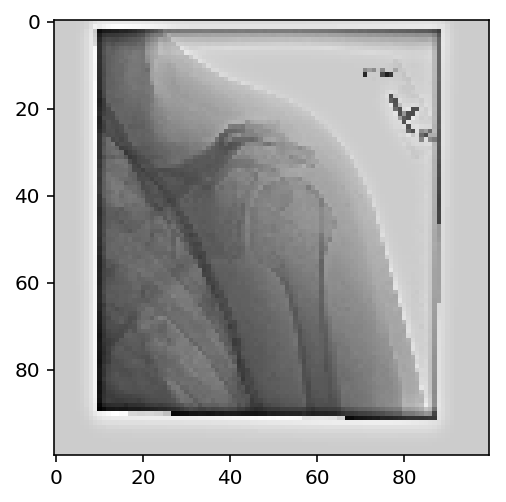

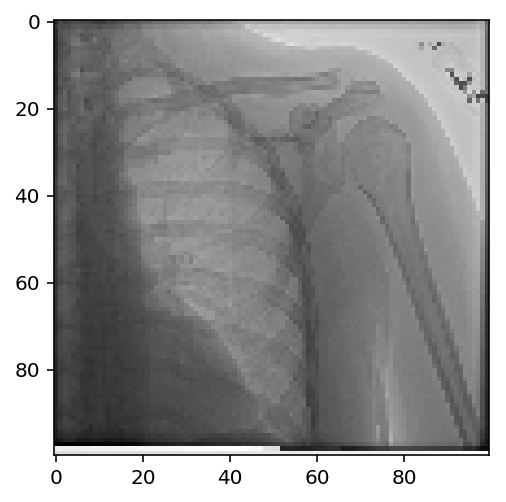

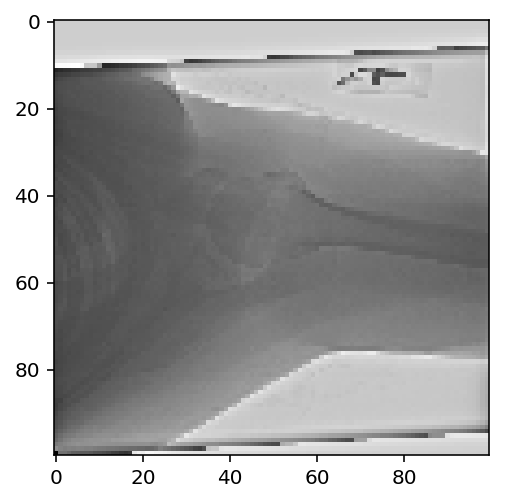

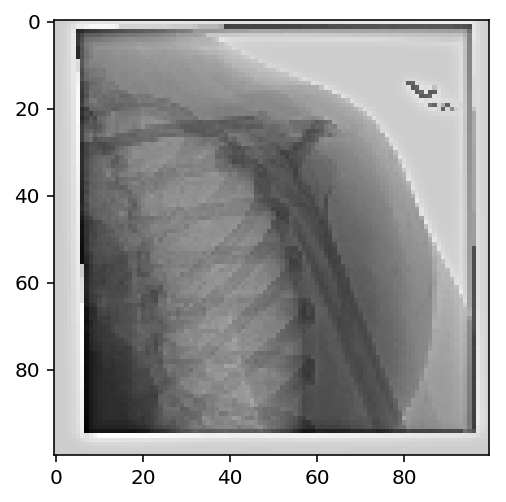

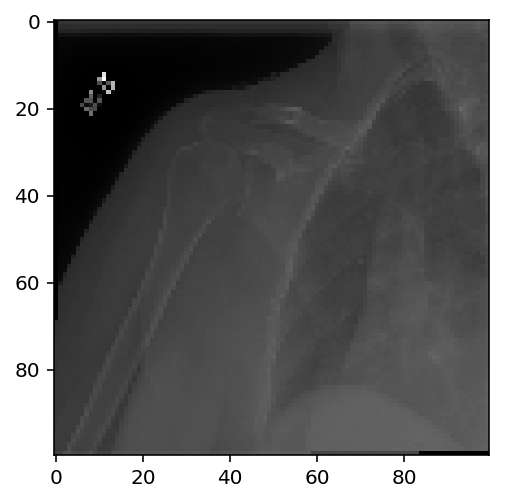

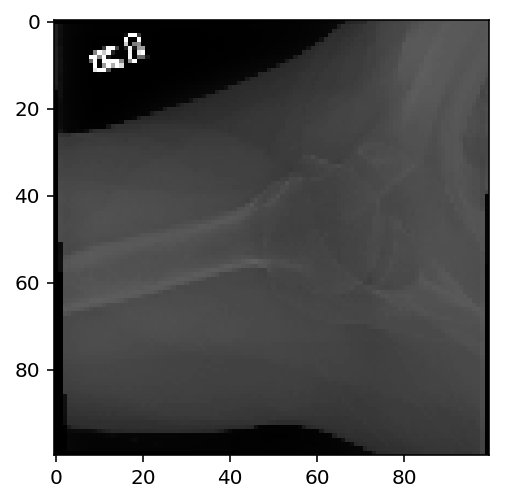

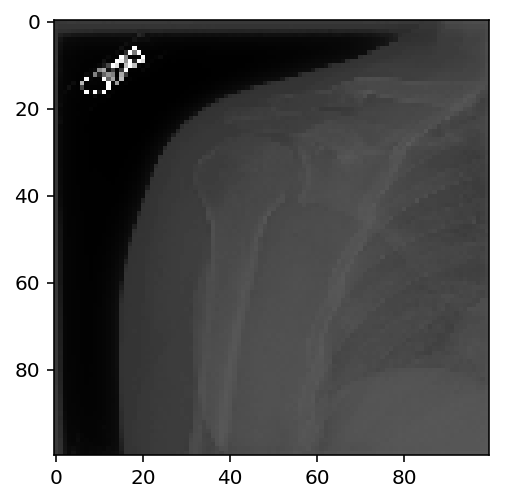

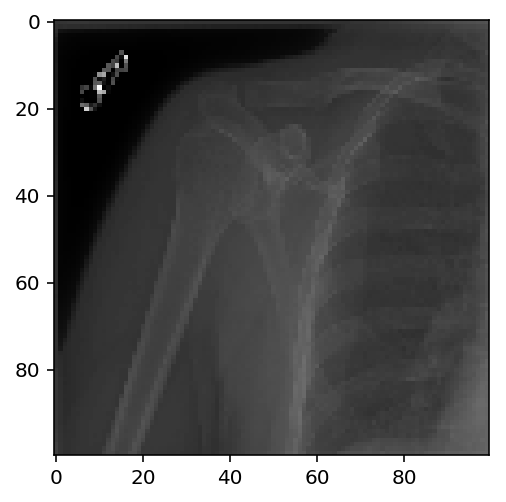

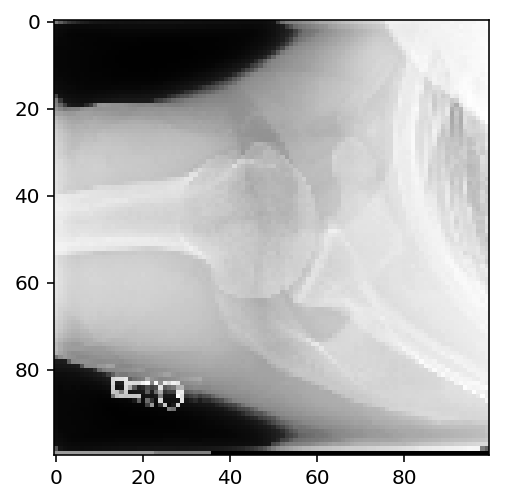

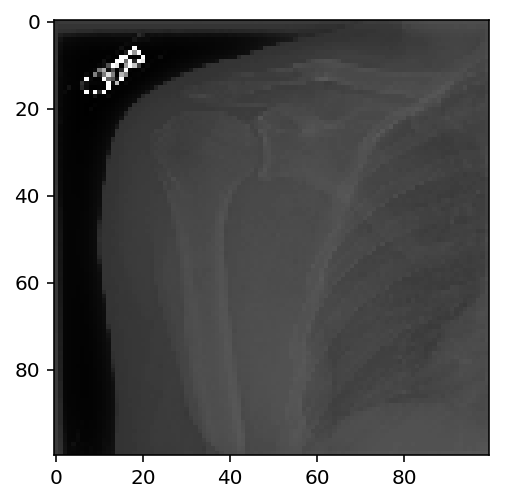

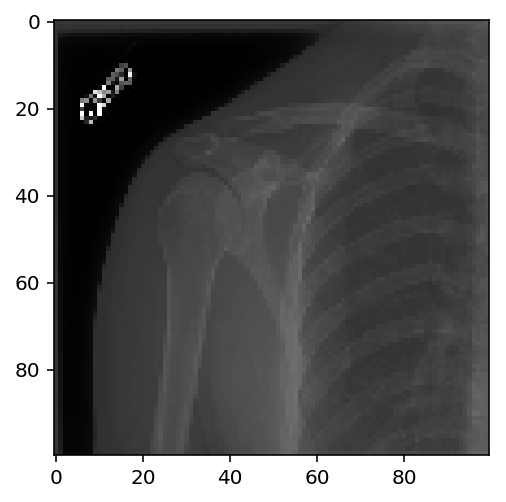

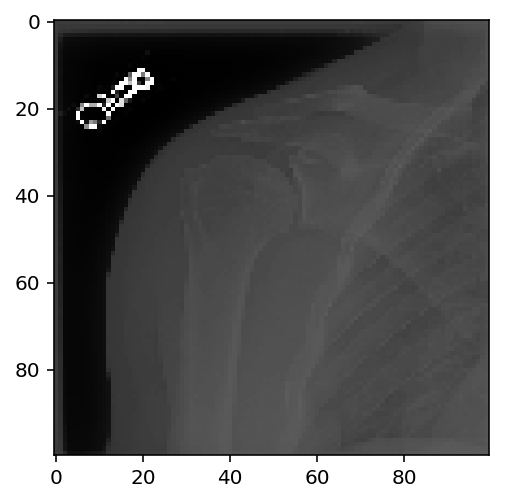

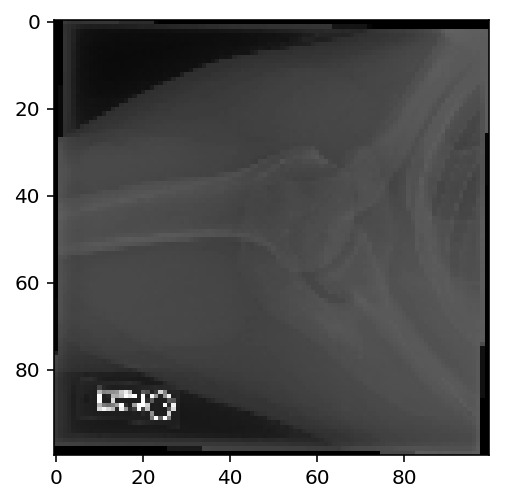

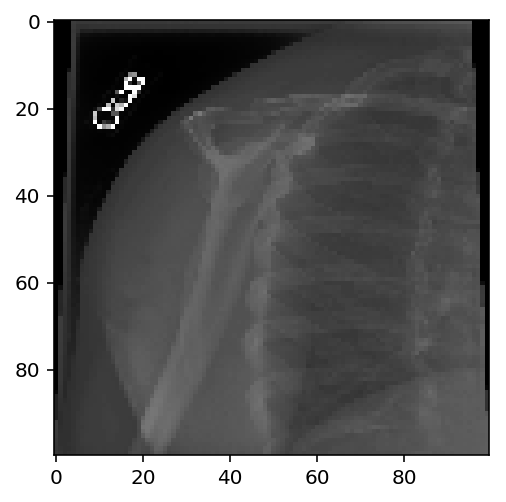

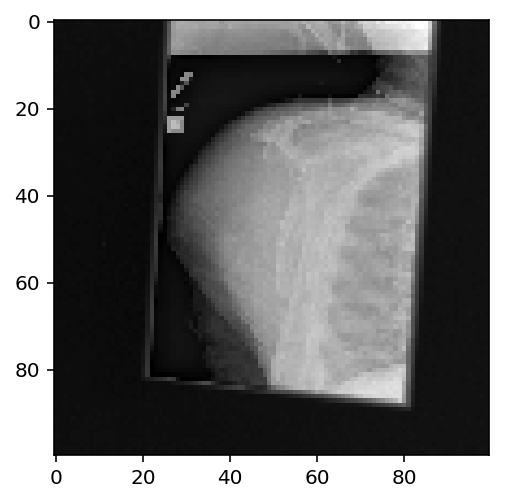

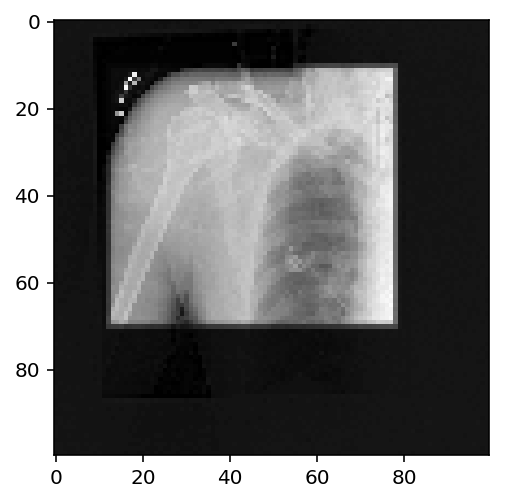

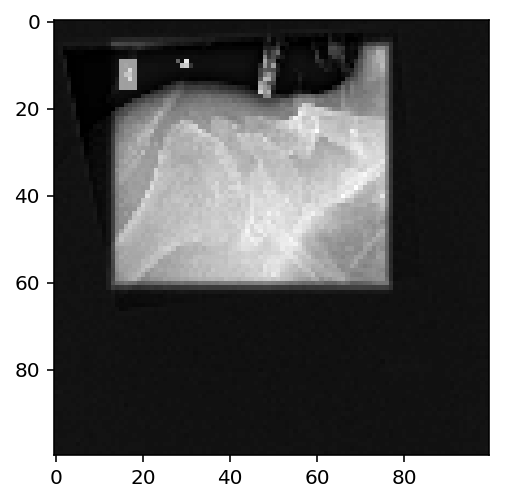

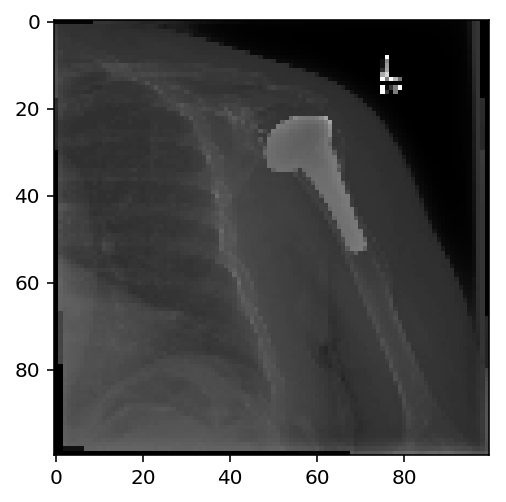

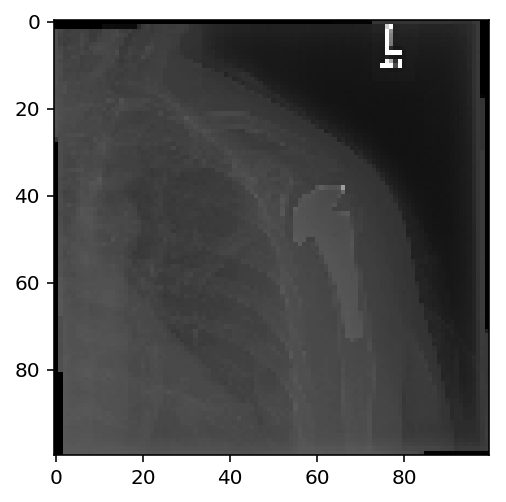

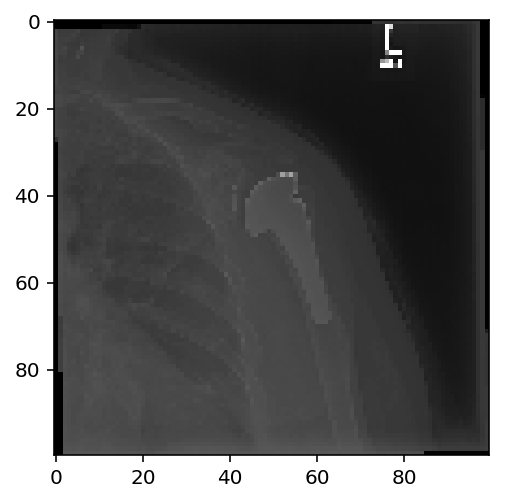

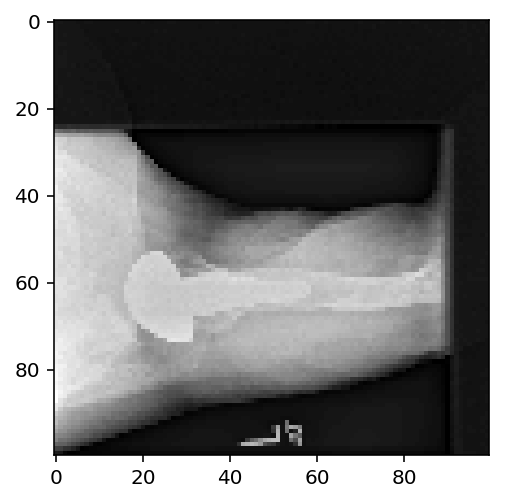

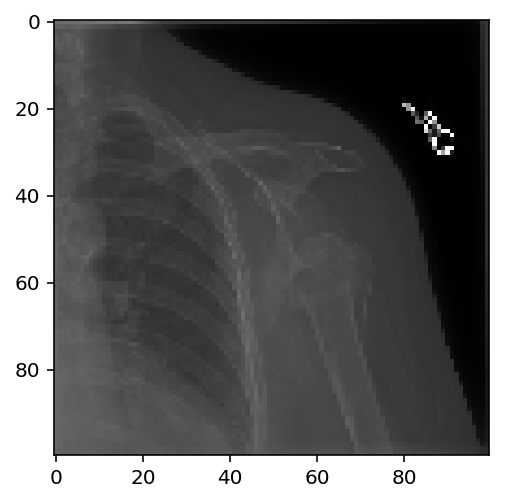

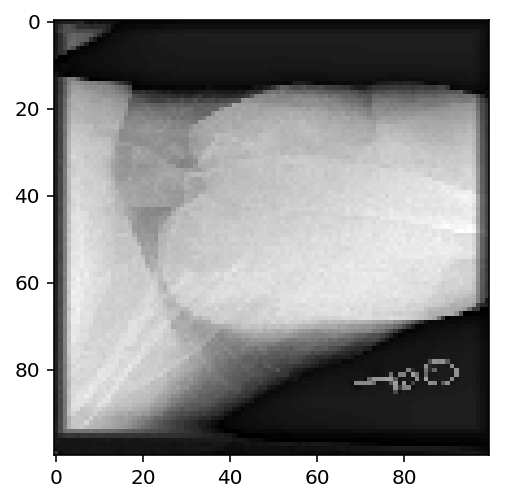

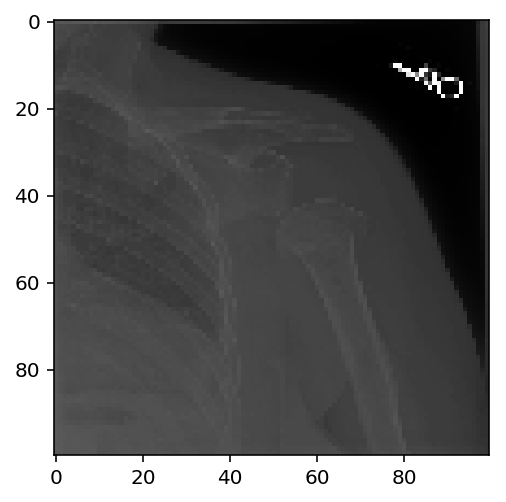

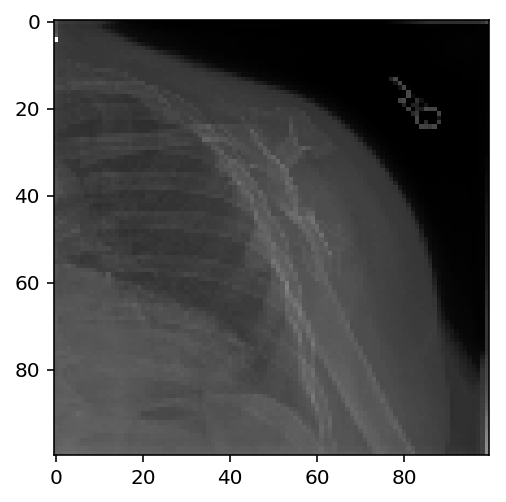

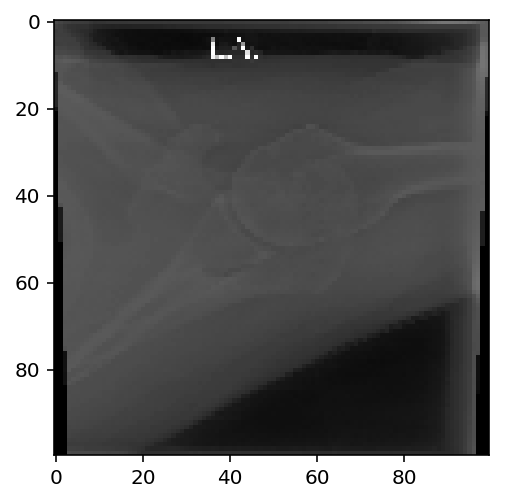

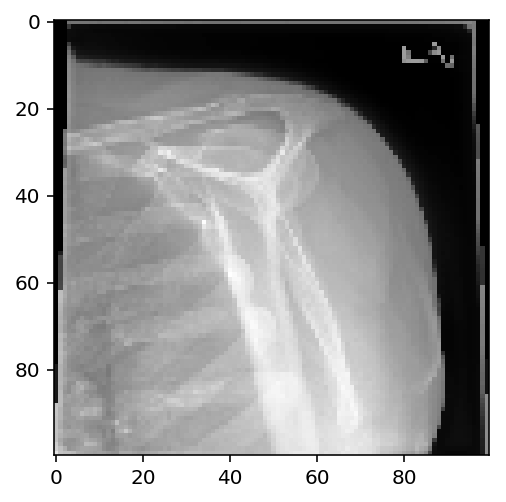

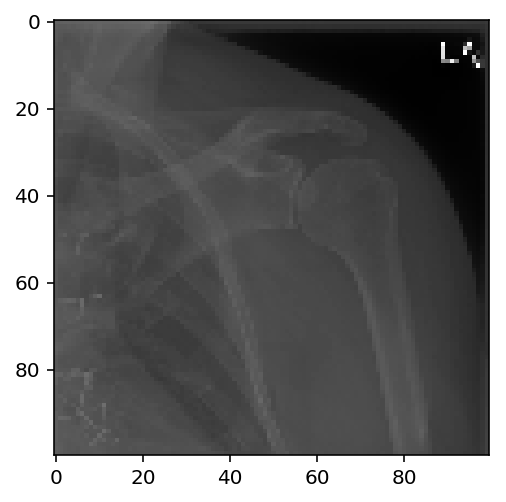

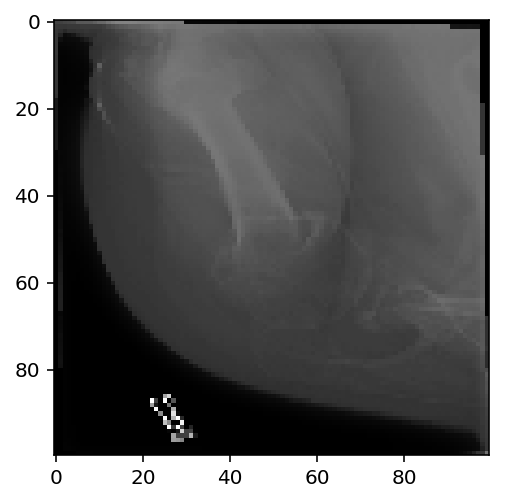

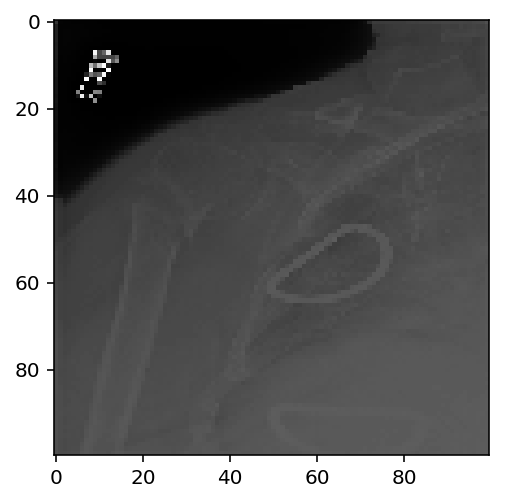

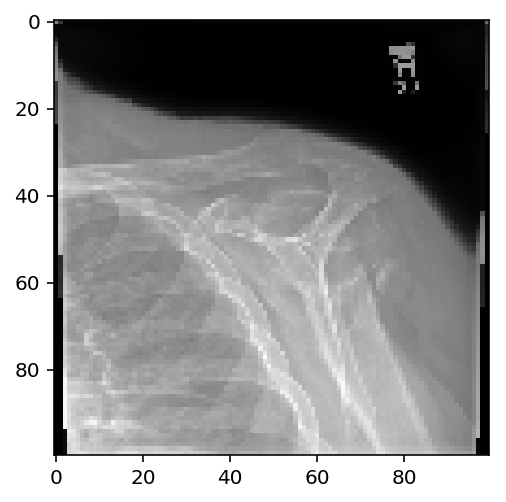

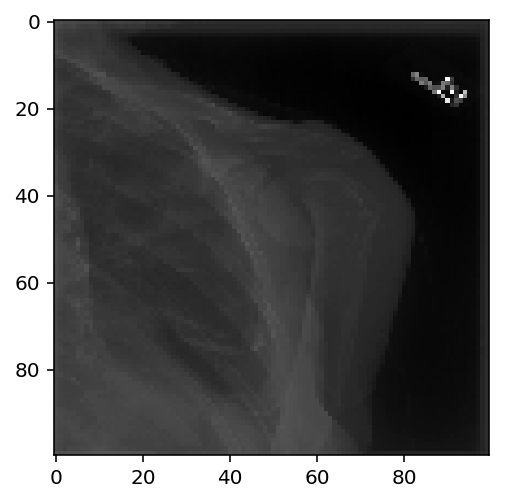

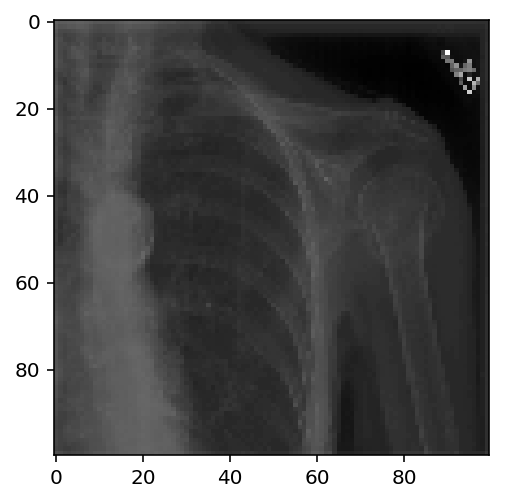

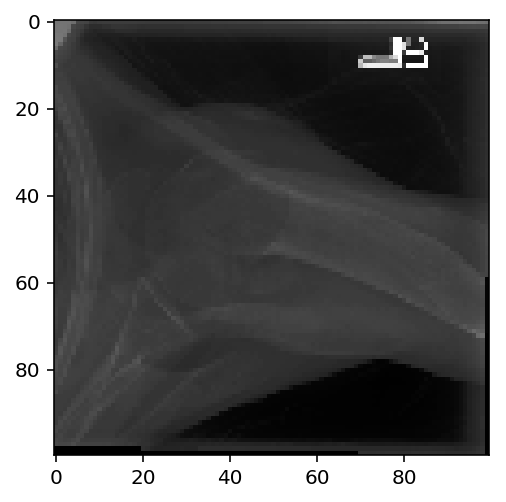

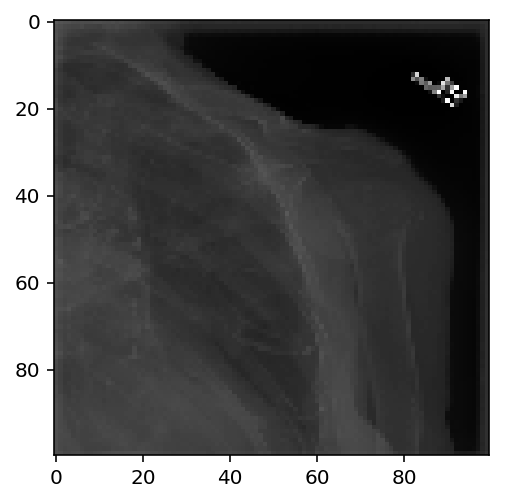

0.975549369064572


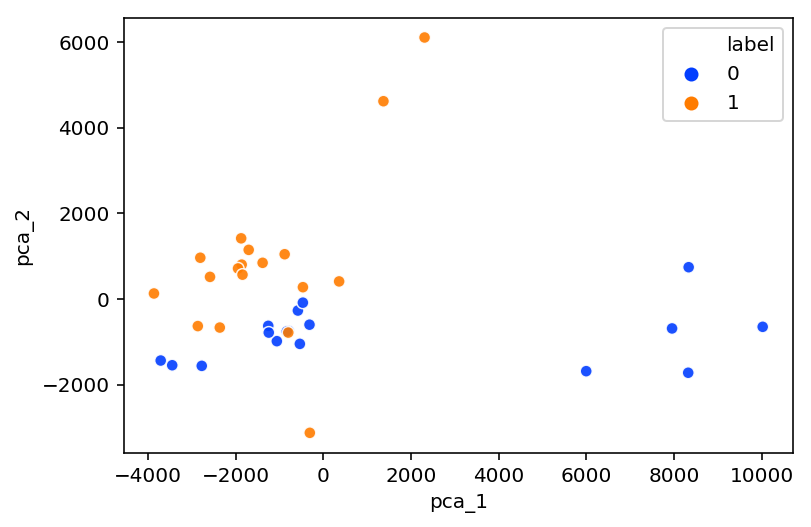

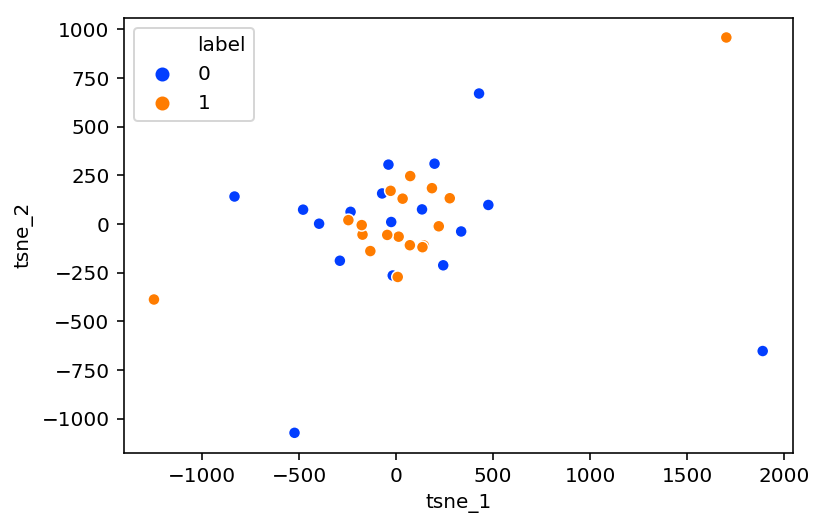

In [75]:
# Notice we could only explain ~6% with thresholding
shoulder = pca_tsne_bpart(train_labels, n_studies=5, bpart='SHOULDER', mode='norm_abnorm')
pca, pca_result = shoulder.perform_pca(n_comp=20)
_ = shoulder.perform_tsne(perplexity=5, n_comp=3)

### image reconstruction from pca

In [76]:
pcainv = pca.inverse_transform(pca_result)

In [77]:
pcainv.shape

(35, 10000)

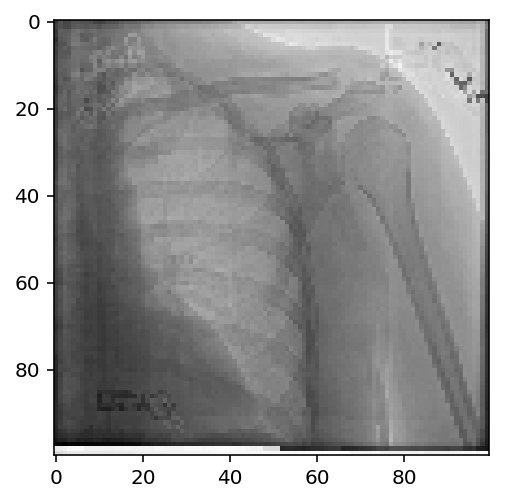

In [79]:
plt.imshow(pcainv[1].reshape(100,100).T, cmap='gray')